# KKProject_6_NewData

In this notebook I'll be exploring newer data (modified data collection technique in the arduino)



## Improvement from before

Accelerometers are mass spring systems. As such, the acceleration they measure is based on forces, and not on a change in velocity (as one might expect from an accelerometer). 

Therefore, in the axis that is vertical (and thus in line with gravity), you will always read an acceleration of 1 g due to gravity. So... if you do a movement in the direction of gravity, i.e. translate vertically downwards, then you will register accelerations < 1 g.

This solution can be fixed.

Consider having a global vatiable, g

g = 1

v = MeasureAccelerationInVerticalAxis() // will read '1'

v = v - g

// thus giving a value of 0
// this effectically fixes the error

Since there are 3 axes, you actually need a vector, so your equation will be something like this:

$$ \underline{g} = \begin{pmatrix}g_1\\g_2 \\ g_3 \end{pmatrix} $$

$$ \underline{v} \leftarrow \frac{\mathrm{d^2}}{\mathrm{d}t^2}\left(\underline{x}\right) $$

$$ \underline{v} \leftarrow \underline{v} - \underline{g}$$

**Note:** in an ieal scenario, the values $g_1$, $g_2$ and $g_3$ would be configured such that a total value of 1 acts in the 'vertical' axis of the movement detection device. For the time being, since that is difficult to measure, a 'cutoff' value has been added that accounts for some error, so effectively the final equation is something like this:

$$ \underline{v} \leftarrow (1-\alpha)\underline{v} - \alpha\underline{g} $$

## Libraries needed

In [2]:
# file management
import os
import pickle

# mathematical
import numpy as np
from scipy.spatial.distance import cdist 

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# modelling

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

## Functions

In [3]:
def directory_to_df(path,filetype = '.csv'):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    filetype: a string of the file extension (must include .)
    """
    
    frames = []
    for filename in os.listdir(path):
        if filetype in filename:
            frames.append(pd.read_csv(path+filename))
        
    df = pd.concat(frames,ignore_index = True)
    return df

## New data

In [6]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/'

df = directory_to_df(path)

columns = df.columns.values.tolist()
columns.remove('date')
df.drop('gyrZ',inplace = True, axis = 1)

df.columns = columns
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))

df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,accTotal,gyrTotal
0,0.08,0.01,0.11,-13.49,5.99,-21.58,0.136382,26.144915
1,0.05,-0.03,-0.12,22.86,23.19,-1.88,0.133417,32.617328
2,0.00,-0.01,0.00,4.29,-5.49,7.91,0.010000,10.540982
3,-0.03,0.06,-0.14,-16.51,-0.30,-1.01,0.155242,16.543585
4,-0.01,0.00,0.01,2.25,-21.86,11.49,0.014142,24.798028


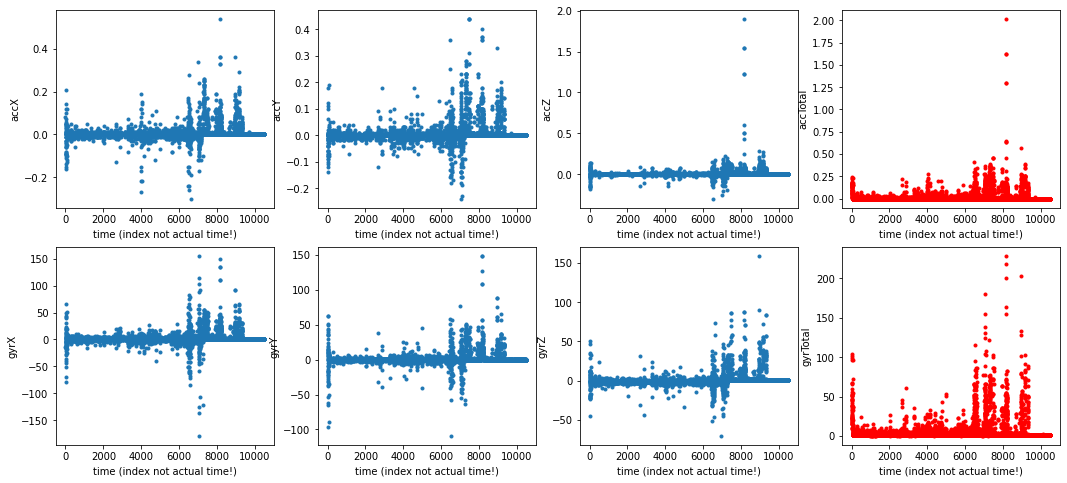

In [7]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'r.')
        else:
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'.')
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1
plt.show()

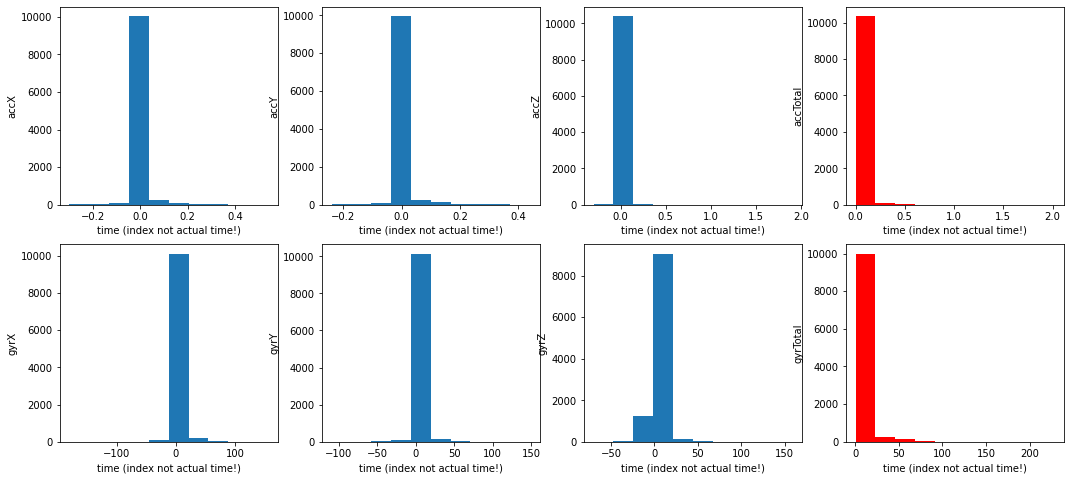

In [8]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.hist(df['{}{}'.format(parameter,plot)],color = 'red')
        else:
            plt.hist(df['{}{}'.format(parameter,plot)])
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1

Text(0, 0.5, 'acceleration')

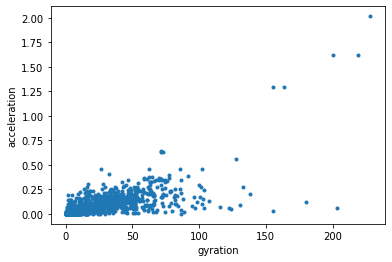

In [9]:
plt.plot(df.gyrTotal,df.accTotal,'.')
plt.xlabel('gyration')
plt.ylabel('acceleration')

## DBSCAN

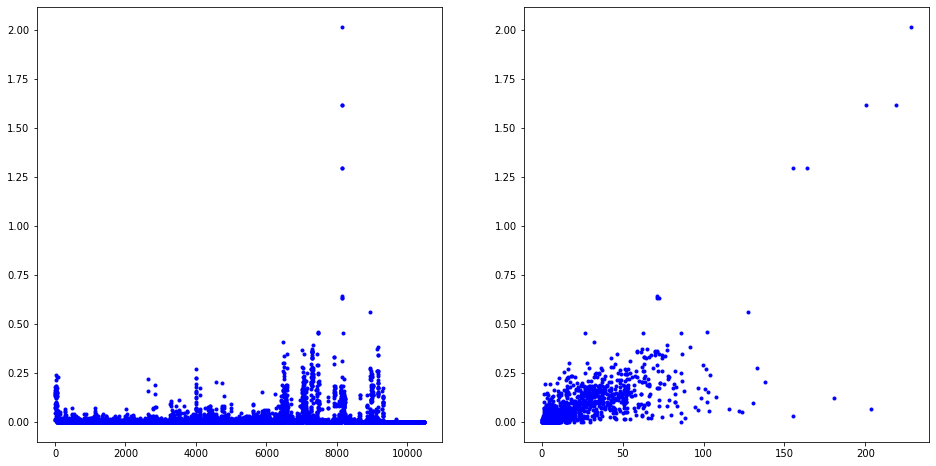

In [14]:
X = np.asarray(df[['accTotal','gyrTotal']])
normalizer = MinMaxScaler()
X = normalizer.fit_transform(X)

model = DBSCAN(eps = 1,min_samples = 1000).fit(X)
true_false = []
for item in model.labels_:
    if item == 0:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]

plt.figure(figsize = (16,8))

plt.subplot(121)
plt.plot(anomalies.index,anomalies.accTotal,'r.')
plt.plot(actuals.index,actuals.accTotal,'b.')
plt.subplot(122)
plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
plt.show()

## Isolation Forest

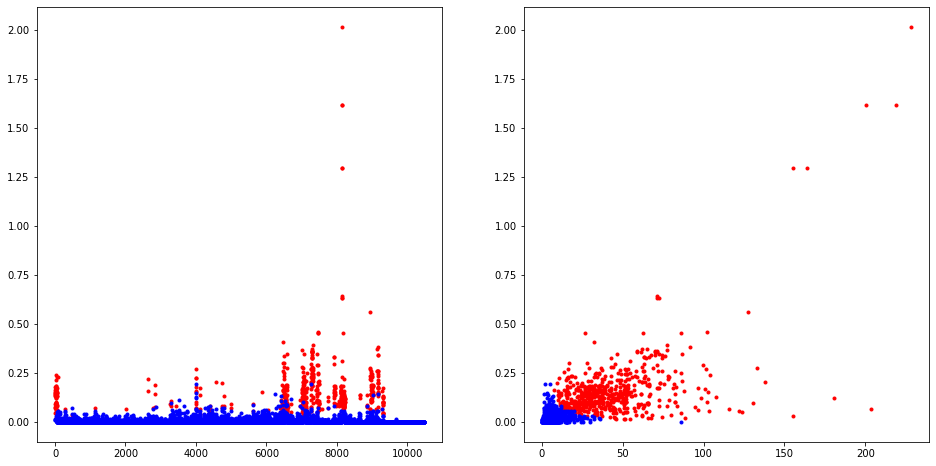

In [20]:
power = 100
model = IsolationForest(n_estimators = power, max_features = 1,contamination = 0.055,random_state = 0\
                       ).fit(X)
output = model.predict(X)
true_false = []
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]

plt.figure(figsize = (16,8))

plt.subplot(121)
plt.plot(anomalies.index,anomalies.accTotal,'r.')
plt.plot(actuals.index,actuals.accTotal,'b.')
plt.subplot(122)
plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
plt.show()

## Test Data

In [83]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Data/TestData/'

filetype = '.csv'
frames = []
test_type = []
test_column = []
test_index = 1
for filename in os.listdir(path):
    if filetype in filename:
        curr_df = pd.read_csv(path+filename)
        frames.append(pd.read_csv(path+filename))
        test_type.append(filename.replace(filetype,''))
        
        for i in range(curr_df.shape[0]):
            test_column.append(test_index)

    test_index+=1
            
        
df_test = pd.concat(frames)
df_test['type'] = test_column

columns = df_test.columns.values.tolist()
columns.remove('date')
df_test.drop('gyrZ',inplace = True, axis = 1)

df_test.columns = columns
df_test['accTotal'] = np.sqrt(np.power(df_test[['accX','accY','accZ']],2).sum(axis = 1))
df_test['gyrTotal'] = np.sqrt(np.power(df_test[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))

df_test.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,type,accTotal,gyrTotal
2020-09-11 12:21:15,0.05,0.40,0.90,0.70,0.91,0.46,1,0.986154,1.236810
2020-09-11 12:21:16,0.05,0.37,0.92,0.16,0.95,0.14,1,0.992875,0.973499
2020-09-11 12:21:16,0.05,0.37,0.92,1.07,1.86,1.73,1,0.992875,2.756338
2020-09-11 12:21:17,0.06,0.37,0.92,1.07,1.86,1.73,1,0.993428,2.756338
2020-09-11 12:21:18,0.10,0.28,0.95,12.04,11.03,5.43,1,0.995440,17.207772


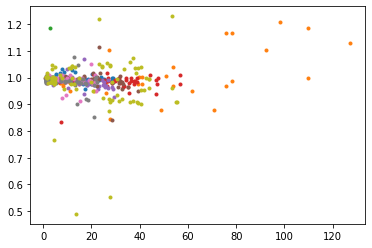

In [98]:
colors = ['blue','green','black','red','purple','yellow','cyan','pink','orange']

for color, test_type in zip(colors,df_test.type.unique()):
    plt.plot(df_test.gyrTotal[df_test.type == test_type],df_test.accTotal[df_test.type == test_type],'.')

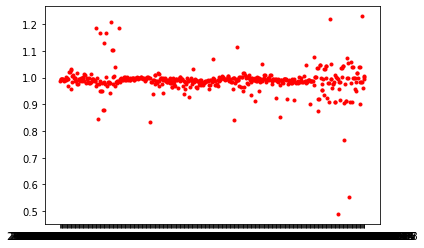

In [89]:

plt.plot(df_test.index, df_test.accTotal,'r.')

## Notes:

- Data does not seem to be in the 'corrected' format. 
- Require Rohan to clarify this
- for our model with iForest, -1 --> anomaly --> significant movement, and 1 --> normal --> noise 

In [122]:
def findBestModel(X_train, X_test, Y_test, model):
    """ Function to find the best parameters to use for a given model 
    components: 
    X_train: numpy array of the input data
    X_test: list containing numpy arrays of different test data
    Y_test: list containing numpy array of different test outcomes (note that this is configured differently 
    for different algorithms,for iForest, each column must have -1 or 1. -1 --> the anomaly, if 1 --> not an anomaly)
    model: string to determine model type
    """
    if model == 'iForest':
        for max_features in range(1,X_train.shape[1]+1):
            for contamination in range(0,101):
                iForest = IsolationForest(n_estimators = 100, max_features = max_features/1000,\
                                         contamination = contamination, random_state = 0).fit(X_train)
                for x_test,y_test in zip(X_test,Y_test):
                    y_hat = iForest.predict(x_test)
                    score = evaluate(y_test,y_hat) # returns accuracy score
                    print(score)
def evaluate(y_test, y_hat):
    """ function to evaluate the score of a predicted array and a 'ground truth' array
    components:
    y_test:
    y_hat:
    """
    score = np.sum(y_test==y_hat)
    return score 
    print('test')
    